In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import VotingClassifier

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [3]:
titanik = sns.load_dataset('titanic')
titanik

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [4]:
titanik['embarked'].value_counts(),titanik['embark_town'].value_counts()

(embarked
 S    644
 C    168
 Q     77
 Name: count, dtype: int64,
 embark_town
 Southampton    644
 Cherbourg      168
 Queenstown      77
 Name: count, dtype: int64)

In [5]:
titanik['survived'].value_counts(),titanik['alive'].value_counts()

(survived
 0    549
 1    342
 Name: count, dtype: int64,
 alive
 no     549
 yes    342
 Name: count, dtype: int64)

In [6]:
titanik['sex'].value_counts(),titanik['who'].value_counts()

(sex
 male      577
 female    314
 Name: count, dtype: int64,
 who
 man      537
 woman    271
 child     83
 Name: count, dtype: int64)

In [7]:
titanik['pclass'].value_counts(),titanik['class'].value_counts()

(pclass
 3    491
 1    216
 2    184
 Name: count, dtype: int64,
 class
 Third     491
 First     216
 Second    184
 Name: count, dtype: int64)

In [8]:
titanik.drop(['embarked','alive','sex','pclass'], axis = 1, inplace=True)

In [9]:
titanik.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   age          714 non-null    float64 
 2   sibsp        891 non-null    int64   
 3   parch        891 non-null    int64   
 4   fare         891 non-null    float64 
 5   class        891 non-null    category
 6   who          891 non-null    object  
 7   adult_male   891 non-null    bool    
 8   deck         203 non-null    category
 9   embark_town  889 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(3), object(2)
memory usage: 52.8+ KB


In [10]:
titanik.describe()

,survived,age,sibsp,parch,fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
titanik.head(10)

,survived,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone
0,0,22.0,1,0,7.2500,Third,man,True,NaN,Southampton,False
1,1,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False
2,1,26.0,0,0,7.9250,Third,woman,False,NaN,Southampton,True
3,1,35.0,1,0,53.1000,First,woman,False,C,Southampton,False
4,0,35.0,0,0,8.0500,Third,man,True,NaN,Southampton,True
5,0,NaN,0,0,8.4583,Third,man,True,NaN,Queenstown,True
6,0,54.0,0,0,51.8625,First,man,True,E,Southampton,True
7,0,2.0,3,1,21.0750,Third,child,False,NaN,Southampton,False
8,1,27.0,0,2,11.1333,Third,woman,False,NaN,Southampton,False
9,1,14.0,1,0,30.0708,Second,child,False,NaN,Cherbourg,False


In [12]:
titanik.columns

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'class', 'who',
       'adult_male', 'deck', 'embark_town', 'alone'],
      dtype='object')

In [13]:
titanik['class'].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [14]:
titanik['deck'].value_counts()

deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64

In [15]:
titanik.groupby('deck', observed=True)['age'].mean()

deck
A    44.833333
B    34.955556
C    36.086667
D    39.032258
E    38.116667
F    19.954545
G    14.750000
Name: age, dtype: float64

In [16]:
pd.crosstab(titanik['deck'], titanik['class'])

class,First,Second,Third
deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4


In [17]:
pd.crosstab(titanik['deck'], titanik['who'])

who,child,man,woman
deck,,,
A,1,13,1
B,3,19,25
C,2,31,26
D,0,15,18
E,1,16,15
F,4,5,4
G,2,0,2


In [18]:
x = titanik[['deck','who','class','age','fare']]
x

,deck,who,class,age,fare
0,NaN,man,Third,22.0,7.2500
1,C,woman,First,38.0,71.2833
2,NaN,woman,Third,26.0,7.9250
3,C,woman,First,35.0,53.1000
4,NaN,man,Third,35.0,8.0500
...,...,...,...,...,...
886,NaN,man,Second,27.0,13.0000
887,B,woman,First,19.0,30.0000
888,NaN,woman,Third,NaN,23.4500
889,C,man,First,26.0,30.0000


In [19]:
x = titanik.drop('survived', axis = 1)
x

,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone
0,22.0,1,0,7.2500,Third,man,True,NaN,Southampton,False
1,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False
2,26.0,0,0,7.9250,Third,woman,False,NaN,Southampton,True
3,35.0,1,0,53.1000,First,woman,False,C,Southampton,False
4,35.0,0,0,8.0500,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,Second,man,True,NaN,Southampton,True
887,19.0,0,0,30.0000,First,woman,False,B,Southampton,True
888,NaN,1,2,23.4500,Third,woman,False,NaN,Southampton,False
889,26.0,0,0,30.0000,First,man,True,C,Cherbourg,True


In [20]:
x.columns

Index(['age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [21]:
ordinalTrans = OrdinalEncoder()
dummyTrans = OneHotEncoder( handle_unknown= 'ignore')
numericTrans = StandardScaler()

In [22]:
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ['deck', 'class']),
                                 ('dummy', dummyTrans, ['sibsp','parch','who','adult_male','embark_town','alone']),
                                 ('numeric', numericTrans, ['age','fare'])])
imputer = KNNImputer()
pipe = Pipeline([('preproc', preprocessor),
                 ('impute', imputer)])

In [23]:
pipe.fit_transform(x)

array([[ 4.2       ,  2.        ,  0.        , ...,  0.        ,
        -0.53037664, -0.50244517],
       [ 2.        ,  0.        ,  0.        , ...,  0.        ,
         0.57183099,  0.78684529],
       [ 4.6       ,  2.        ,  1.        , ...,  1.        ,
        -0.25482473, -0.48885426],
       ...,
       [ 5.4       ,  2.        ,  0.        , ...,  0.        ,
        -0.17215916, -0.17626324],
       [ 2.        ,  0.        ,  1.        , ...,  1.        ,
        -0.25482473, -0.04438104],
       [ 4.8       ,  2.        ,  1.        , ...,  1.        ,
         0.15850313, -0.49237783]], shape=(891, 29))

In [24]:
pipe.named_steps['preproc'].named_transformers_['dummy'].get_feature_names_out()

array(['sibsp_0', 'sibsp_1', 'sibsp_2', 'sibsp_3', 'sibsp_4', 'sibsp_5',
       'sibsp_8', 'parch_0', 'parch_1', 'parch_2', 'parch_3', 'parch_4',
       'parch_5', 'parch_6', 'who_child', 'who_man', 'who_woman',
       'adult_male_False', 'adult_male_True', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton',
       'embark_town_nan', 'alone_False', 'alone_True'], dtype=object)

In [25]:
pipe.named_steps

{'preproc': ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                  ['deck', 'class']),
                                 ('dummy',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['sibsp', 'parch', 'who', 'adult_male',
                                   'embark_town', 'alone']),
                                 ('numeric', StandardScaler(), ['age', 'fare'])]),
 'impute': KNNImputer()}

In [26]:
xtrans = pipe.fit_transform(x)
xtrans[0]

array([ 4.2       ,  2.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        , -0.53037664, -0.50244517])

In [27]:
ordinal = pipe.named_steps['preproc'].named_transformers_['ordinal'].inverse_transform(xtrans[:, :2])
dummy = pipe.named_steps['preproc'].named_transformers_['dummy'].inverse_transform(xtrans[:, 2:-2])
numeric = pipe.named_steps['preproc'].named_transformers_['numeric'].inverse_transform(xtrans[:, -2:])

In [28]:
print(ordinal[:5], dummy[:5], numeric[:5], sep ='\n')

[['E' 'Third']
 ['C' 'First']
 ['E' 'Third']
 ['C' 'First']
 ['E' 'Third']]
[[1 0 'man' True 'Southampton' False]
 [1 0 'woman' False 'Cherbourg' False]
 [0 0 'woman' False 'Southampton' True]
 [1 0 'woman' False 'Southampton' False]
 [0 0 'man' True 'Southampton' True]]
[[22.      7.25  ]
 [38.     71.2833]
 [26.      7.925 ]
 [35.     53.1   ]
 [35.      8.05  ]]


In [29]:
x['deck'].value_counts().sort_index()

deck
A    15
B    47
C    59
D    33
E    32
F    13
G     4
Name: count, dtype: int64

In [30]:
x = pd.concat([
        pd.DataFrame(ordinal, columns=['deck', 'class']),
        pd.DataFrame(dummy,columns=['sibsp', 'parch', 'who', 'adult_male', 'embark_town', 'alone']),
        pd.DataFrame(numeric, columns=['age', 'fare'])
    ], axis=1)
x

,deck,class,sibsp,parch,who,adult_male,embark_town,alone,age,fare
0,E,Third,1,0,man,True,Southampton,False,22.0,7.2500
1,C,First,1,0,woman,False,Cherbourg,False,38.0,71.2833
2,E,Third,0,0,woman,False,Southampton,True,26.0,7.9250
3,C,First,1,0,woman,False,Southampton,False,35.0,53.1000
4,E,Third,0,0,man,True,Southampton,True,35.0,8.0500
...,...,...,...,...,...,...,...,...,...,...
886,C,Second,0,0,man,True,Southampton,True,27.0,13.0000
887,B,First,0,0,woman,False,Southampton,True,19.0,30.0000
888,F,Third,1,2,woman,False,Southampton,False,27.2,23.4500
889,C,First,0,0,man,True,Cherbourg,True,26.0,30.0000


In [31]:
pd.crosstab(x['deck'], x['class']) - pd.crosstab(titanik['deck'], titanik['class'])

class,First,Second,Third
deck,,,
A,5,1,0
B,18,22,0
C,15,70,1
D,3,37,20
E,0,29,380
F,0,9,78
G,0,0,0


In [32]:
pd.crosstab(titanik['deck'], titanik['class'])

class,First,Second,Third
deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4


In [33]:
titanik[x.columns] = x

In [34]:
titanik

,survived,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone
0,0,22.0,1,0,7.2500,Third,man,True,E,Southampton,False
1,1,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False
2,1,26.0,0,0,7.9250,Third,woman,False,E,Southampton,True
3,1,35.0,1,0,53.1000,First,woman,False,C,Southampton,False
4,0,35.0,0,0,8.0500,Third,man,True,E,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,Second,man,True,C,Southampton,True
887,1,19.0,0,0,30.0000,First,woman,False,B,Southampton,True
888,0,27.2,1,2,23.4500,Third,woman,False,F,Southampton,False
889,1,26.0,0,0,30.0000,First,man,True,C,Cherbourg,True


In [35]:
titanik.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   age          891 non-null    float64
 2   sibsp        891 non-null    object 
 3   parch        891 non-null    object 
 4   fare         891 non-null    float64
 5   class        891 non-null    object 
 6   who          891 non-null    object 
 7   adult_male   891 non-null    object 
 8   deck         891 non-null    object 
 9   embark_town  889 non-null    object 
 10  alone        891 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 76.7+ KB


In [36]:
titanik['familySize'] = titanik['sibsp'] + titanik['parch'] + 1

In [37]:
titanik[(titanik['deck'] == 'E') & (titanik['embark_town'] == 'Southampton')].head(35).sort_values(by = [ 'class','familySize'])

,survived,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone,familySize
6,0,54.00,0,0,51.8625,First,man,True,E,Southampton,True,1
92,0,46.00,1,0,61.1750,First,man,True,E,Southampton,False,2
17,1,33.20,0,0,13.0000,Second,man,True,E,Southampton,True,1
56,1,21.00,0,0,10.5000,Second,woman,False,E,Southampton,True,1
98,1,34.00,0,1,23.0000,Second,woman,False,E,Southampton,False,2
78,1,0.83,0,2,29.0000,Second,child,False,E,Southampton,False,3
2,1,26.00,0,0,7.9250,Third,woman,False,E,Southampton,True,1
4,0,35.00,0,0,8.0500,Third,man,True,E,Southampton,True,1
12,0,20.00,0,0,8.0500,Third,man,True,E,Southampton,True,1
14,0,14.00,0,0,7.8542,Third,child,False,E,Southampton,True,1


In [38]:
titanik['farePerPerson'] = titanik['fare'] / titanik['familySize']

In [39]:
titanik['classDeck'] = titanik['class'] + '_' + titanik['deck']

In [40]:
titanik

,survived,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone,familySize,farePerPerson,classDeck
0,0,22.0,1,0,7.2500,Third,man,True,E,Southampton,False,2,3.625,Third_E
1,1,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False,2,35.64165,First_C
2,1,26.0,0,0,7.9250,Third,woman,False,E,Southampton,True,1,7.925,Third_E
3,1,35.0,1,0,53.1000,First,woman,False,C,Southampton,False,2,26.55,First_C
4,0,35.0,0,0,8.0500,Third,man,True,E,Southampton,True,1,8.05,Third_E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,Second,man,True,C,Southampton,True,1,13.0,Second_C
887,1,19.0,0,0,30.0000,First,woman,False,B,Southampton,True,1,30.0,First_B
888,0,27.2,1,2,23.4500,Third,woman,False,F,Southampton,False,4,5.8625,Third_F
889,1,26.0,0,0,30.0000,First,man,True,C,Cherbourg,True,1,30.0,First_C


In [41]:
x = titanik.iloc[:,1:]
y = titanik.iloc[:,0]

In [42]:
x

,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone,familySize,farePerPerson,classDeck
0,22.0,1,0,7.2500,Third,man,True,E,Southampton,False,2,3.625,Third_E
1,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False,2,35.64165,First_C
2,26.0,0,0,7.9250,Third,woman,False,E,Southampton,True,1,7.925,Third_E
3,35.0,1,0,53.1000,First,woman,False,C,Southampton,False,2,26.55,First_C
4,35.0,0,0,8.0500,Third,man,True,E,Southampton,True,1,8.05,Third_E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,Second,man,True,C,Southampton,True,1,13.0,Second_C
887,19.0,0,0,30.0000,First,woman,False,B,Southampton,True,1,30.0,First_B
888,27.2,1,2,23.4500,Third,woman,False,F,Southampton,False,4,5.8625,Third_F
889,26.0,0,0,30.0000,First,man,True,C,Cherbourg,True,1,30.0,First_C


In [43]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64

In [44]:
y.mean(), len(y) * .8

(np.float64(0.3838383838383838), 712.8000000000001)

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= .2, stratify= y, random_state= 42)

In [46]:
x.columns

Index(['age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'deck',
       'embark_town', 'alone', 'familySize', 'farePerPerson', 'classDeck'],
      dtype='object')

In [47]:
ordinalTrans = OrdinalEncoder()
dummyTrans = OneHotEncoder( handle_unknown= 'ignore', drop = 'first')
numericTrans = StandardScaler()

In [48]:
ordinal = ['deck', 'class', 'familySize']
dummy = ['sibsp','parch','who','adult_male','embark_town','alone','classDeck']
numeric = ['age','fare','farePerPerson']

In [49]:
def provera(model):
    # model = model.best_estimator_
    train, test = model.score(xtrain,ytrain), model.score(xtest,ytest)
    pred = model.predict(xtest)
    roc, f1 = roc_auc_score(ytest, pred), f1_score(ytest,pred)
    return train, test, roc, f1

In [ ]:
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])
logit = LogisticRegression(max_iter= 1000)
pipe = Pipeline([('preproc', preprocessor),
                 ('logit', logit)])

In [ ]:
pipe.fit(xtrain, ytrain)

In [ ]:
pipe.score(xtrain, ytrain)

In [ ]:
logit = LogisticRegression()
pipe = Pipeline([('preproc', preprocessor),
                 ('logit', logit)])
grid = {
    'logit__C': np.logspace(-3, 3, 7),  # Testiramo vrednosti C od 10^-3 do 10^3
    'logit__penalty': ['l1', 'l2'],
    'logit__max_iter': [500, 1000, 2000], # L1 i L2 regularizacija
    'logit__solver': ['liblinear'],  # Solver koji je pogodan za l1 regularizaciju
}
random = RandomizedSearchCV(pipe, grid, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [ ]:
random.fit(xtrain, ytrain)

In [ ]:
random.best_estimator_.score(xtrain, ytrain)

In [ ]:
logit = LogisticRegression()
poly = PolynomialFeatures(interaction_only=True, include_bias=False)  
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', Pipeline([
                                                     ('ohe',dummyTrans),
                                                     ('poly', poly)]),
                                  dummy),
                                 ('numeric', numericTrans, numeric)])
pipe = Pipeline([('preproc', preprocessor),
                 ('logit', logit)])
grid = {
    'logit__C': np.logspace(-3, 3, 7),  # Testiramo vrednosti C od 10^-3 do 10^3
    'logit__penalty': ['l1', 'l2'],
    'logit__max_iter': [500, 1000, 2000], # L1 i L2 regularizacija
    'logit__solver': ['liblinear'],  # Solver koji je pogodan za l1 regularizaciju
    'preproc__dummy__poly__degree': [2, 3]

}
random = RandomizedSearchCV(pipe, grid, n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [ ]:
random.fit(xtrain,ytrain)

In [ ]:
random.best_estimator_.score(xtrain,ytrain)

In [ ]:
grid = {
    'logit__C': np.logspace(-3, 3, 7),  # Testiramo vrednosti C od 10^-3 do 10^3
    'logit__penalty': ['l1', 'l2'],
    'logit__max_iter': [500, 1000, 2000], 
    'logit__solver': ['liblinear'],  # Solver koji je pogodan za l1 regularizaciju
    'preproc__dummy__poly__degree': [2, 3]

}
random = RandomizedSearchCV(pipe, grid, n_iter=100, cv=10, n_jobs=-1, scoring='accuracy', random_state=42)
random.fit(xtrain,ytrain)

In [ ]:
best.score(xtrain,ytrain)

In [ ]:
best = random.best_estimator_
best.score(xtrain,ytrain)

In [ ]:
best.score(xtest,ytest)

In [ ]:
pred = best.predict(xtest)
roc_auc_score(ytest, pred), f1_score(ytest, pred)

In [ ]:
rezultati = pd.DataFrame({'best': [best.score(xtrain,ytrain),best.score(xtest,ytest),roc_auc_score(ytest, pred), f1_score(ytest, pred)]},index=['treningScore','testScore','roc','f1'])
rezultati

In [ ]:
grid = {
    'logit__C': np.logspace(-3, 3, 7),  # Testiramo vrednosti C od 10^-3 do 10^3
    'logit__penalty': ['l1', 'l2'],
    'logit__max_iter': [500, 1000, 2000], 
    'logit__solver': ['liblinear'],  # Solver koji je pogodan za l1 regularizaciju
    'preproc__dummy__poly__degree': [2, 3]

}
random = RandomizedSearchCV(pipe, grid, n_iter=100, cv=10, n_jobs=-1, scoring='f1', random_state=42)
random.fit(xtrain,ytrain)

random

In [ ]:
random

In [ ]:
random = random.best_estimator_

In [ ]:
random.score(xtrain,ytrain),random.score(xtest,ytest), best.score(xtrain,ytrain), best.score(xtest,ytest)

In [ ]:
roc_auc_score(ytest, random.predict(xtest)),f1_score(ytest, random.predict(xtest))

In [ ]:
roc_auc_score(ytest, best.predict(xtest)),f1_score(ytest, best.predict(xtest))

In [ ]:
rezultati['random'] = [random.score(xtrain,ytrain), random.score(xtest,ytest), roc_auc_score(ytest, random.predict(xtest)), f1_score(ytest, random.predict(xtest))]

In [ ]:
rezultati

In [ ]:
grid = {
    'logit__C': np.logspace(-3, 3, 7),  # Testiramo vrednosti C od 10^-3 do 10^3
    'logit__penalty': ['l1', 'l2'],
    'logit__max_iter': [500, 1000, 2000], 
    'logit__solver': ['liblinear'],  # Solver koji je pogodan za l1 regularizaciju
    'preproc__dummy__poly__degree': [2, 3]

}
balanced = RandomizedSearchCV(pipe, grid, n_iter=100, cv=10, n_jobs=-1, scoring='balanced_accuracy', random_state=42)
balanced.fit(xtrain,ytrain)

balanced

In [ ]:
balanced = balanced.best_estimator_

In [ ]:
balanced.score(xtrain,ytrain),balanced.score(xtest,ytest), roc_auc_score(ytest, balanced.predict(xtest)),f1_score(ytest, balanced.predict(xtest))

In [ ]:
rezultati

In [ ]:
svc = SVC()

In [ ]:
preprocessorSVC = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])
pipe = Pipeline([('preproc', preprocessorSVC),
                 ('svc', svc)])
grid = {
    'svc__C': np.logspace(0.1, 1, 10),  # Testiramo vrednosti C od 10^-3 do 10^3
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],  # Tip kernela
    'svc__gamma': ['scale', 'auto'],  # Parametar gamma
    'svc__class_weight': ['balanced', None],  # Da li je potrebno balansirati klase
}
model = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=grid,
    n_iter=50, 
    cv=10, 
    n_jobs=-1, 
    verbose=3, 
    scoring='balanced_accuracy',
    random_state=42  # Da bi imali reprodusibilnost
)

In [ ]:
model.fit(xtrain, ytrain)

In [ ]:
model = model.best_estimator_

In [ ]:
model.score(xtrain,ytrain), model.score(xtest,ytest)

In [ ]:
predSVC = model.predict(xtest)

In [ ]:
roc_auc_score(predSVC, ytest), f1_score(predSVC, ytest)

In [ ]:
rezultati['SVC'] = [model.score(xtrain,ytrain), model.score(xtest,ytest),roc_auc_score(predSVC, ytest), f1_score(predSVC, ytest)]

In [ ]:
rezultati = joblib.load('titanikRezultati.pkl')

In [ ]:
rezultati

In [ ]:
np.logspace(0.1, 1.5, 30)

In [ ]:
grid = {
    'svc__C': np.logspace(0.1, 1.5, 30),  # Testiramo vrednosti C od 10^-3 do 10^3
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],  # Tip kernela
    'svc__gamma': ['scale', 'auto'],  # Parametar gamma
    'svc__class_weight': ['balanced', None],  # Da li je potrebno balansirati klase
}
model2 = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=grid,  # Ispravno ime
    n_iter=50, 
    cv=10, 
    n_jobs=-1, 
    verbose=3, 
    scoring='balanced_accuracy',  # Ispravan naziv scoring-a
    random_state=42  # Da bi imali reprodusibilnost
)

In [ ]:
model2.fit(xtrain,ytrain)

In [ ]:
model2.score(xtrain,ytrain), model2.score(xtest,ytest)

In [ ]:
predSVC2 = model2.predict(xtest)

In [ ]:
roc_auc_score(predSVC2, ytest), f1_score(predSVC2, ytest)

In [ ]:
rezultati['SVC2'] = [model2.score(xtrain,ytrain), model2.score(xtest,ytest), roc_auc_score(predSVC2, ytest), f1_score(predSVC2, ytest)] 

In [ ]:
rezultati

In [ ]:
joblib.dump(balanced, 'titanikLogit.pkl')
joblib.dump(model, 'titanikSVC.pkl')
joblib.dump(rezultati, 'titanikRezultati.pkl')

In [ ]:
imenik = {'rezultati': 'titanikRezultati.pkl','svc' : 'titanikSVC.pkl', 'logit' : 'titanikLogit.pkl'}
imenik

In [ ]:
for i,j in imenik.items():
    imenik[i] = joblib.load(j)

In [ ]:
svc = imenik['svc']
logit = imenik['logit']
rezultati = imenik['rezultati']

In [ ]:
rezltati, svc, logit

In [ ]:
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])

ridgePipe = Pipeline([('prep', preprocessor), ('model', RidgeClassifier())])
grid = {'model__alpha': np.logspace(0,2,10), 'model__class_weight': [None, 'balanced']}
ridge = RandomizedSearchCV(estimator = ridgePipe,param_distributions = grid, cv = 10, scoring='balanced_accuracy',n_iter=20, n_jobs= -1)
ridge.fit(xtrain, ytrain)

In [49]:
rezultati = joblib.load('titanikRezultati.pkl')
rezultati

,logit,logit2,logit3,SVC,SVC2,ridge,ridge2,rf,rf2,rf3,knn,knn2
treningScore,0.851124,0.844101,0.844101,0.830056,0.812770,0.827247,0.827247,0.898876,0.905899,0.848315,0.855337,0.855337
testScore,0.804469,0.810056,0.810056,0.832402,0.807773,0.815642,0.815642,0.787709,0.810056,0.793296,0.810056,0.810056
roc,0.781489,0.786034,0.786034,0.827176,0.822029,0.804084,0.804084,0.778656,0.794137,0.791304,0.791436,0.791436
f1,0.728682,0.734375,0.734375,0.772727,0.763359,0.759124,0.759124,0.728571,0.746269,0.744828,0.742424,0.742424


In [ ]:
rezultati['ridge'] = provera(ridge)
rezultati

In [ ]:
grid2 = {
    'model__alpha': np.logspace(-3, 3, 15),  # Alpha može biti od 10^-3 do 10^3 (više vrednosti)
    'model__class_weight': [None, 'balanced'],  # Za balansiranje klasa ili ne
    'model__max_iter': [100, 200, 500, 1000],  # Različiti brojevi iteracija
    'model__solver': ['auto', 'lsqr', 'saga'],  # Različiti solveri za optimizaciju
}
ridge2 = RandomizedSearchCV(estimator = ridgePipe,param_distributions = grid2, cv = 10, scoring='balanced_accuracy',n_iter=200, n_jobs= -1)
ridge2.fit(xtrain,ytrain)

In [ ]:
joblib.dump(ridge2, 'titanikRidge.pkl')

In [ ]:
rezultati['ridge2'] = provera(ridge2)
rezultati

In [ ]:
boost = xgb.XGBClassifier()


In [ ]:
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='mlogloss'))
])
param_grid = {
    'model__learning_rate': np.logspace(-3, 0, 4),  # Brzina učenja od 0.001 do 1
    'model__n_estimators': [50, 100, 200],  # Broj stabala u modelu
    'model__max_depth': [3, 5, 7],  # Maksimalna dubina svakog stabla
    'model__subsample': [0.8, 0.9, 1.0],  # Procenat podataka koji će biti korišćen za svaki model
    'model__colsample_bytree': [0.8, 0.9, 1.0],  # Koliko kolona (feature-a) koristiti za svako stablo
    'model__gamma': [0, 0.1, 0.2],  # Kontrola složenosti stabala
    'model__scale_pos_weight': [1, 2, 3],  # Koristi se za balansiranje klasifikacije u nebalansiranim skupovima
    'model__reg_alpha': [0, 0.01, 0.1],  # L1 regularizacija
    'model__reg_lambda': [0, 0.01, 0.1],  # L2 regularizacija
}
boost = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,  # Broj iteracija za random search
    cv=5,  # Cross-validation sa 3 podele
    verbose=3,  # Detaljan ispis
    n_jobs=-1,  # Korišćenje svih dostupnih procesora
    scoring='balanced_accuracy',  # Metrika koja se koristi za ocenjivanje
    random_state=42
)
boost.fit(xtrain, ytrain)

In [ ]:
rezultati['boost'] = provera(boost)
rezultati

In [ ]:
grid2 = {
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [3, 5, 7],
    'model__gamma': [0.1, 0.2, 0.3],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__scale_pos_weight': [1, 2, 3],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [0, 0.01, 0.1]
}
boost2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=grid2,
    n_iter=100,  
    cv=5,  
    verbose=2,  # Detaljan ispis
    n_jobs=-1,  # Korišćenje svih dostupnih procesora
    scoring='balanced_accuracy',  # Metrika koja se koristi za ocenjivanje
    random_state=42
)
boost2.fit(xtrain, ytrain)

In [ ]:
rezultati['boost2'] = provera(boost2)
rezultati

In [ ]:
preprocRf =  ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ordinal),
    ('dummy', dummyTrans, dummy)# Transformacija samo ovih kolona
], remainder='passthrough')

rfPipe = Pipeline(steps=[
    ('preprocessor', preprocRf),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))  # Paralelna obrada
])

# Grid Search parametri
grid = {
    'model__n_estimators': np.random.randint(50, 300, 10),  # Broj stabala u šumi
    'model__max_depth': [10, 20, 30, 40, 50],  # Maksimalna dubina stabala
    'model__min_samples_split': [2, 5, 10],  # Minimalan broj uzoraka za deljenje čvora
    'model__min_samples_leaf': [1, 2, 4],  # Minimalan broj uzoraka po listu
    'model__max_features': ['sqrt', 'log2', None],  # Koliko feature-a koristiti po stablu
    'model__bootstrap': [True, False],  # Da li koristiti bootstrap sample-ove
    'model__class_weight': [None, 'balanced', 'balanced_subsample']  # Balansiranje klasa
}
rf = RandomizedSearchCV(estimator= rfPipe, param_distributions= grid, cv= 5, n_iter=100, n_jobs= -1, scoring='balanced_accuracy')
rf.fit(xtrain, ytrain)

In [ ]:
rezltati['rf'] = provera(rf)
rezltati

In [ ]:
dummyTrans = OneHotEncoder( handle_unknown= 'ignore')
preprocRf =  ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ordinal),
    ('dummy', dummyTrans, dummy)# Transformacija samo ovih kolona
], remainder='passthrough')

rfPipe = Pipeline(steps=[
    ('preprocessor', preprocRf),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))  # Paralelna obrada
])

# Grid Search parametri
grid = {
    'model__n_estimators': np.random.randint(50, 300, 10),  # Broj stabala u šumi
    'model__max_depth': [10, 20, 30, 40, 50],  # Maksimalna dubina stabala
    'model__min_samples_split': [2, 5, 10],  # Minimalan broj uzoraka za deljenje čvora
    'model__min_samples_leaf': [1, 2, 4],  # Minimalan broj uzoraka po listu
    'model__max_features': ['sqrt', 'log2', None],  # Koliko feature-a koristiti po stablu
    'model__bootstrap': [True, False],  # Da li koristiti bootstrap sample-ove
    'model__class_weight': [None, 'balanced', 'balanced_subsample']  # Balansiranje klasa
}
rf2 = RandomizedSearchCV(estimator= rfPipe, param_distributions= grid, cv= 5, n_iter=200, n_jobs= -1, scoring='balanced_accuracy')
rf2.fit(xtrain, ytrain)

In [ ]:
rezultati['rf2'] = provera(rf2)
rezultati

In [ ]:
joblib.dump(rf2, 'titanikRf.pkl')

In [ ]:
grid = {
    'model__n_estimators': [50, 100, 150, 200, 300],  # Broj stabala u šumi
    'model__max_depth': [ 15, 20, 25, 30, 35],  # Maksimalna dubina stabala
    'model__min_samples_split': [5, 10, 20],  # Minimalan broj uzoraka za deljenje čvora
    'model__min_samples_leaf': [4, 6 ,8],  # Minimalan broj uzoraka po listu
    'model__max_features': ['sqrt', 'log2'],  # Koliko feature-a koristiti po stablu
    'model__bootstrap': [True],  # Da li koristiti bootstrap sample-ove
    'model__class_weight': [None, 'balanced', 'balanced_subsample']  # Balansiranje klasa
}
rf3 = RandomizedSearchCV(estimator= rfPipe, param_distributions= grid, cv= 5, n_iter=200, n_jobs= -1, scoring='balanced_accuracy')
rf3.fit(xtrain, ytrain)

In [ ]:
rezltati['rf3'] = provera(rf3)
rezltati

In [ ]:
ordinalTrans = OrdinalEncoder()
dummyTrans = OneHotEncoder( handle_unknown= 'ignore')
numericTrans = StandardScaler()
ordinal = ['deck', 'class', 'familySize']
dummy = ['sibsp','parch','who','adult_male','embark_town','alone','classDeck']
numeric = ['age','fare','farePerPerson']
preprocessor = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])

pipe = Pipeline([('preproc', preprocessor), ('model', KNeighborsClassifier())])
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}
knn = RandomizedSearchCV(pipe, param_grid, cv=10,n_iter=20, scoring='balanced_accuracy', random_state= 420)
knn.fit(xtrain, ytrain)


In [265]:
rezultati

NameError: name 'rezultati' is not defined

In [52]:
rezultati.iloc[1:].mean().sort_values(ascending = False)

SVC       0.810768
SVC2      0.797720
ridge     0.792950
ridge2    0.792950
rf2       0.783487
knn       0.781305
knn2      0.781305
logit2    0.776822
logit3    0.776822
rf3       0.776476
logit     0.771547
rf        0.764979
dtype: float64

In [ ]:
rezltati['knn'] = provera(knn)
rezltati

In [ ]:
grid2 = {
    'model__n_neighbors': [i for i in range(3,20)],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
    'model__p': [1, 2],  # P=1 za Manhattan, P=2 za Euclidean
    'model__algorithm': ['brute'],
    'model__leaf_size': [20, 30, 40, 50, 60],
    'model__n_jobs': [-1],  # Paralelna obrada, koristi sve jezgre
}
knn2 = RandomizedSearchCV(pipe, grid2, cv=10,n_iter=100, scoring='balanced_accuracy')
knn2.fit(xtrain, ytrain)


In [ ]:
rezltati['knn2'] = provera(knn2)
rezltati

In [53]:
rezultati.iloc[2:].mean().sort_values(ascending = False)

SVC       0.799951
SVC2      0.792694
ridge     0.781604
ridge2    0.781604
rf2       0.770203
rf3       0.768066
knn       0.766930
knn2      0.766930
logit2    0.760205
logit3    0.760205
logit     0.755085
rf        0.753614
dtype: float64

In [54]:
rezultati

,logit,logit2,logit3,SVC,SVC2,ridge,ridge2,rf,rf2,rf3,knn,knn2
treningScore,0.851124,0.844101,0.844101,0.830056,0.812770,0.827247,0.827247,0.898876,0.905899,0.848315,0.855337,0.855337
testScore,0.804469,0.810056,0.810056,0.832402,0.807773,0.815642,0.815642,0.787709,0.810056,0.793296,0.810056,0.810056
roc,0.781489,0.786034,0.786034,0.827176,0.822029,0.804084,0.804084,0.778656,0.794137,0.791304,0.791436,0.791436
f1,0.728682,0.734375,0.734375,0.772727,0.763359,0.759124,0.759124,0.728571,0.746269,0.744828,0.742424,0.742424


In [55]:
svc = joblib.load('titanikSVC.pkl')

In [56]:
svc.fit(xtrain,ytrain)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['deck', 'class',
                                                   'familySize']),
                                                 ('dummy',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sibsp', 'parch', 'who',
                                                   'adult_male', 'embark_town',
                                                   'alone', 'classDeck']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'fare',
                                                   'farePerPerson'])])),
                ('model',
                 SVC(C=1.2589254117941673, class_weight='balanced',
                     gamma='auto', probability=True, random_state=42))])

In [57]:
pca = PCA(n_components=2, random_state=42)
preprocessorSVC = ColumnTransformer([('ordinal', ordinalTrans,  ordinal),
                                 ('dummy', dummyTrans, dummy),
                                 ('numeric', numericTrans, numeric)])
pipe = Pipeline([('preproc', preprocessorSVC), ('pca', pca),])
xprimetr = pipe.fit_transform(xtrain)
xprimetest = pipe.fit_transform(xtest)
model = SVC(C=1.2589254117941673, gamma='auto', kernel='rbf', class_weight='balanced')
model.fit(xprimetr, ytrain)
x1, x2 = np.meshgrid(np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 200), np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 200))
z = model.predict(np.c_[x1.ravel(), x2.ravel()])

In [58]:
z = z.reshape(x1.shape)

In [59]:
z

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], shape=(200, 200))

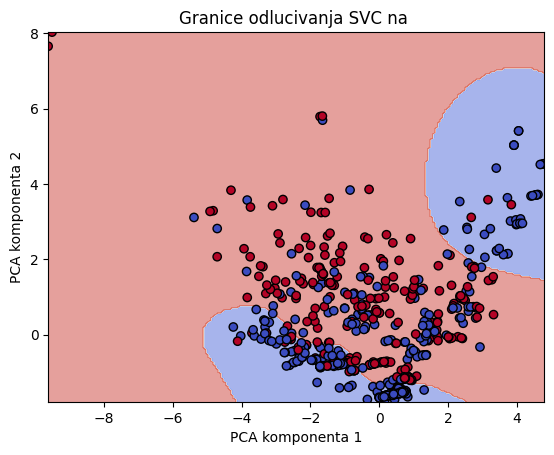

In [60]:
plt.contourf(x1, x2, z, alpha=0.5, cmap='coolwarm')
plt.scatter(xprimetr[:, 0], xprimetr[:, 1], c=ytrain, edgecolor='k', cmap='coolwarm')
plt.xlabel("PCA komponenta 1")
plt.ylabel("PCA komponenta 2")
plt.title("Granice odlucivanja SVC na ")
plt.show()

In [61]:
pca3d = PCA(n_components=3, random_state= 42)
pipe = Pipeline([('preproc', preprocessorSVC), ('pca', pca3d),])
xprimetr = pipe.fit_transform(xtrain)
xprimetest = pipe.fit_transform(xtest)
prosek = np.mean(xprimetr[:, 2])

In [62]:
np.mean(xprimetr[:, 2])

np.float64(3.492836481966785e-16)

In [63]:
model = SVC(C=1.2589254117941673, gamma='auto', kernel='rbf', class_weight='balanced', random_state=42)
model.fit(xprimetr, ytrain)
x1, x2 = np.meshgrid(np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 200), np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 200))
mesh = np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, prosek)]
z = model.predict(np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, prosek)])
z = z.reshape(x1.shape)

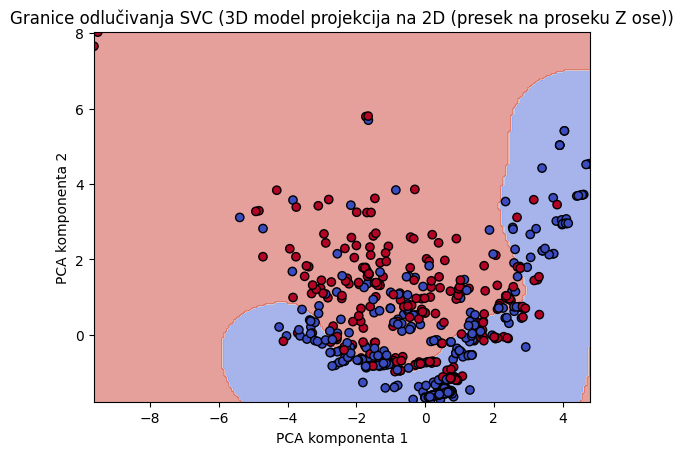

In [64]:
plt.contourf(x1, x2, z, alpha=0.5, cmap='coolwarm')
plt.scatter(xprimetr[:, 0], xprimetr[:, 1], c=ytrain, edgecolor='k', cmap='coolwarm')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.title('Granice odlučivanja SVC (3D model projekcija na 2D (presek na proseku Z ose))')
plt.show()

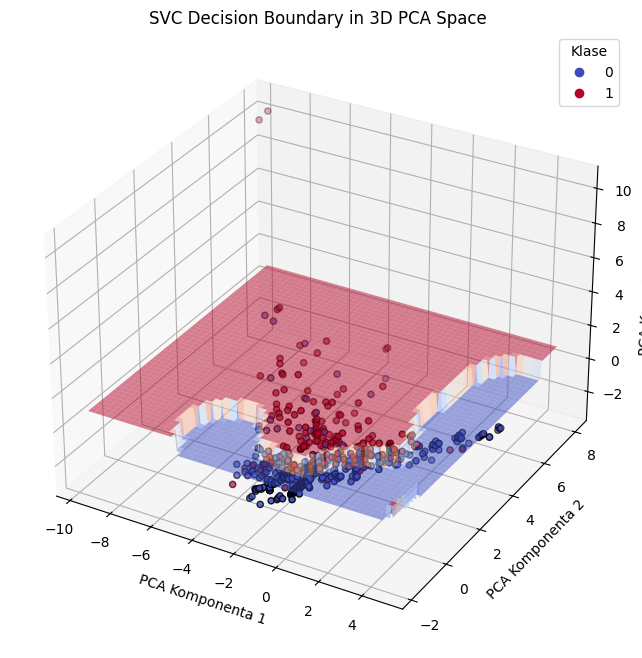

In [65]:

# Kreiranje meshgrid za 2D prostor sa 2 PCA komponente (početne dve komponente za odluku)
x1, x2 = np.meshgrid(np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 200),
                     np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 200))

# Pravimo mesh za predikcije (kombinacija dve komponente i treća je prosek)
prosek = np.mean(xprimetr[:, 2])  # Prosek treće komponente
mesh = np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, prosek)]  # Dodajemo prosek za treću komponentu

# Predikcija za meshgrid (sa dve komponente)
z = model.predict(mesh)
z = z.reshape(x1.shape)  # Preoblikujemo rezultat u odgovarajući oblik za vizualizaciju

# Kreiraj 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prikazivanje originalnih podataka u 3D prostoru
scatter = ax.scatter(xprimetr[:, 0], xprimetr[:, 1], xprimetr[:, 2], c=ytrain, cmap='coolwarm', edgecolor='k')

# Dodavanje oznaka
ax.set_xlabel('PCA Komponenta 1')
ax.set_ylabel('PCA Komponenta 2')
ax.set_zlabel('PCA Komponenta 3')
ax.set_title('SVC Decision Boundary in 3D PCA Space')

# Prikazivanje legende
plt.legend(*scatter.legend_elements(), title="Klase")

# Dodavanje površinske plohe sa predikcijama (decision boundary)
# Prikazivanje odlučujuće granice u 3D prostoru
ax.plot_surface(x1, x2, z, cmap='coolwarm', alpha=0.5)

# Prikazivanje
plt.show()

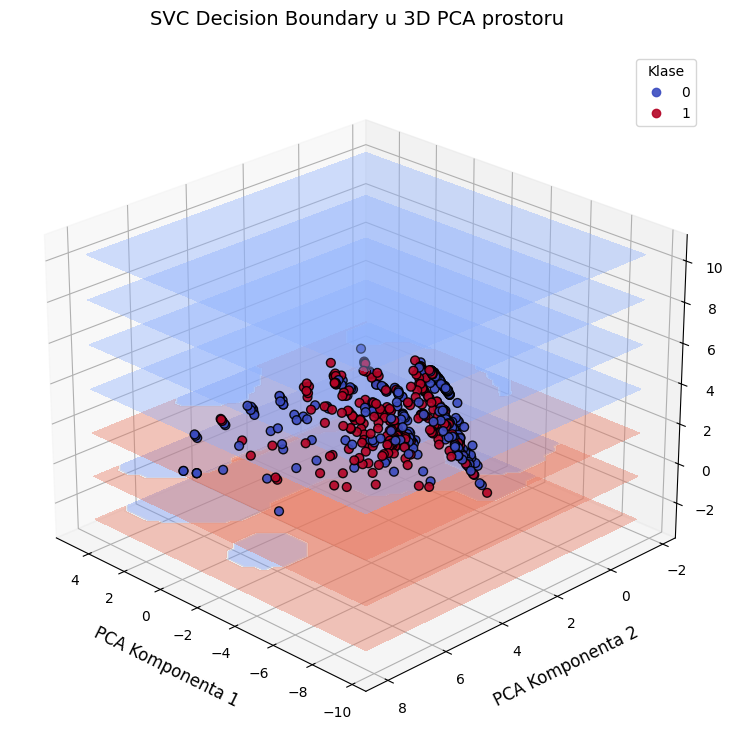

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Kreiramo 3D meshgrid kroz PCA komponente
x1_range = np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 50)
x2_range = np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 50)
x3_range = np.linspace(xprimetr[:, 2].min(), xprimetr[:, 2].max(), 7)  # Smanjio broj slojeva

# Figura i 3D osa
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=135)  # Prilagođen ugao kamere

# Scatter plot originalnih podataka
scatter = ax.scatter(
    xprimetr[:, 0], xprimetr[:, 1], xprimetr[:, 2], 
    c=ytrain, cmap='coolwarm', edgecolor='k', s=40, alpha=0.9
)

# Crtamo slojeve odlučujuće granice kroz PCA3
for x3_val in x3_range:
    x1, x2 = np.meshgrid(x1_range, x2_range)
    grid_points = np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, x3_val)]

    # Model predviđa klase za svaki presek
    z = model.predict(grid_points)
    z = z.reshape(x1.shape)

    # Poboljšana odlučujuća granica
    ax.contourf(
        x1, x2, z, zdir='z', offset=x3_val, 
        cmap='coolwarm', alpha=0.4, levels=2
    )

# Oznake osa i naslov
ax.set_xlabel('PCA Komponenta 1', fontsize=12, labelpad=10)
ax.set_ylabel('PCA Komponenta 2', fontsize=12, labelpad=10)
ax.set_zlabel('PCA Komponenta 3', fontsize=12, labelpad=10)
ax.set_title('SVC Decision Boundary u 3D PCA prostoru', fontsize=14, pad=20)

# Prikazivanje legende
legend = ax.legend(*scatter.legend_elements(), title="Klase", fontsize=10, loc="upper right", frameon=True)
legend.get_frame().set_alpha(0.8)

# Prikazivanje
plt.show()


In [67]:
svc = SVC(C=1.2589254117941673, gamma='auto', kernel='rbf', class_weight='balanced')
model = Pipeline([('preproc', preprocessorSVC), ('model', svc)])
model.fit(xtrain,ytrain)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['deck', 'class',
                                                   'familySize']),
                                                 ('dummy',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sibsp', 'parch', 'who',
                                                   'adult_male', 'embark_town',
                                                   'alone', 'classDeck']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'fare',
                                                   'farePerPerson'])])),
                ('model',
                 SVC(C=1.2589254117941673, class_weight='balanced',
                     gamma='auto'))])

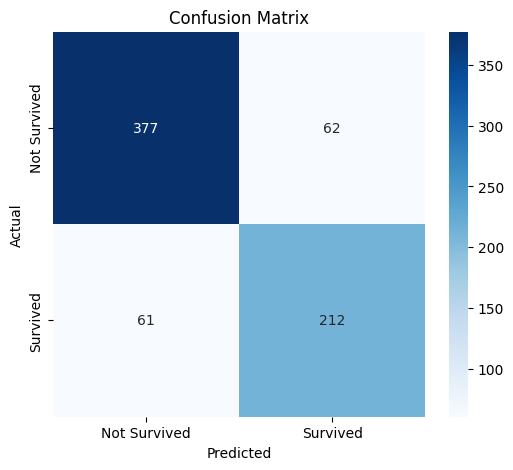


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       439
           1       0.77      0.78      0.78       273

    accuracy                           0.83       712
   macro avg       0.82      0.82      0.82       712
weighted avg       0.83      0.83      0.83       712



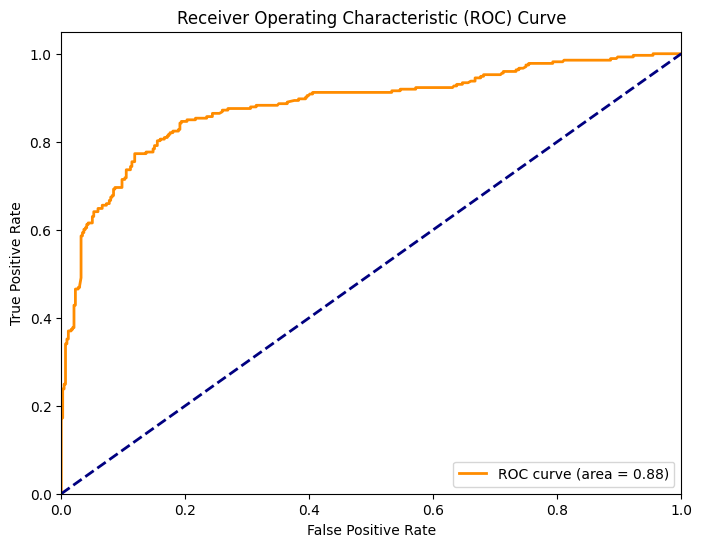

In [68]:
y_pred = model.predict(xtrain)
cm = confusion_matrix(ytrain, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 2️⃣ Klasifikacioni izveštaj
print("\nClassification Report:\n", classification_report(ytrain, y_pred))

# 3️⃣ ROC kriva & AUC
y_scores = model.decision_function(xtrain)
fpr, tpr, _ = roc_curve(ytrain, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


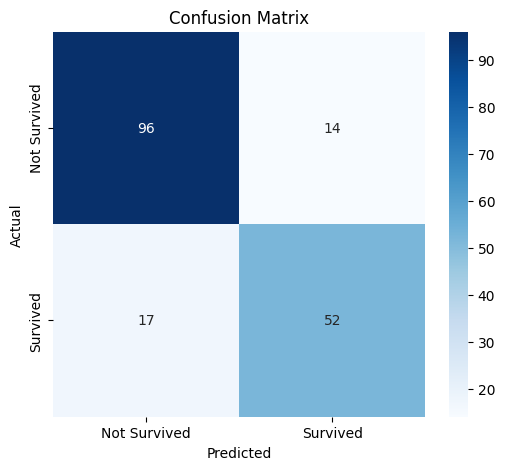


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



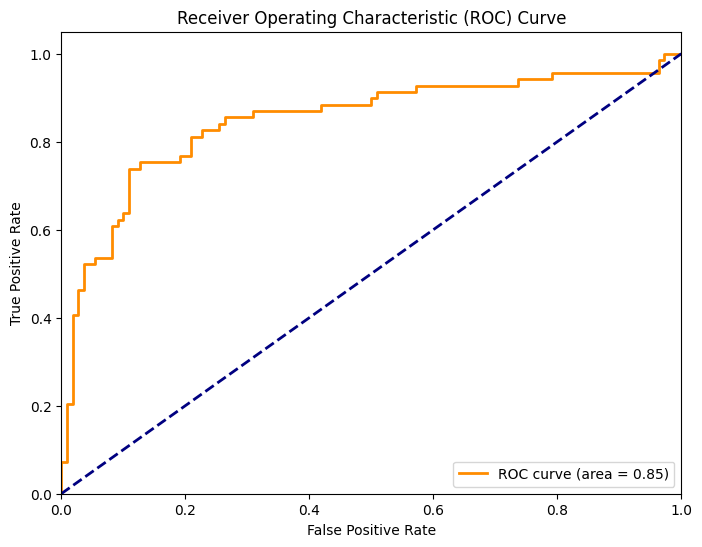

In [69]:
y_pred = model.predict(xtest)
cm = confusion_matrix(ytest, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 2️⃣ Klasifikacioni izveštaj
print("\nClassification Report:\n", classification_report(ytest, y_pred))

# 3️⃣ ROC kriva & AUC
y_scores = model.decision_function(xtest)
fpr, tpr, _ = roc_curve(ytest, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


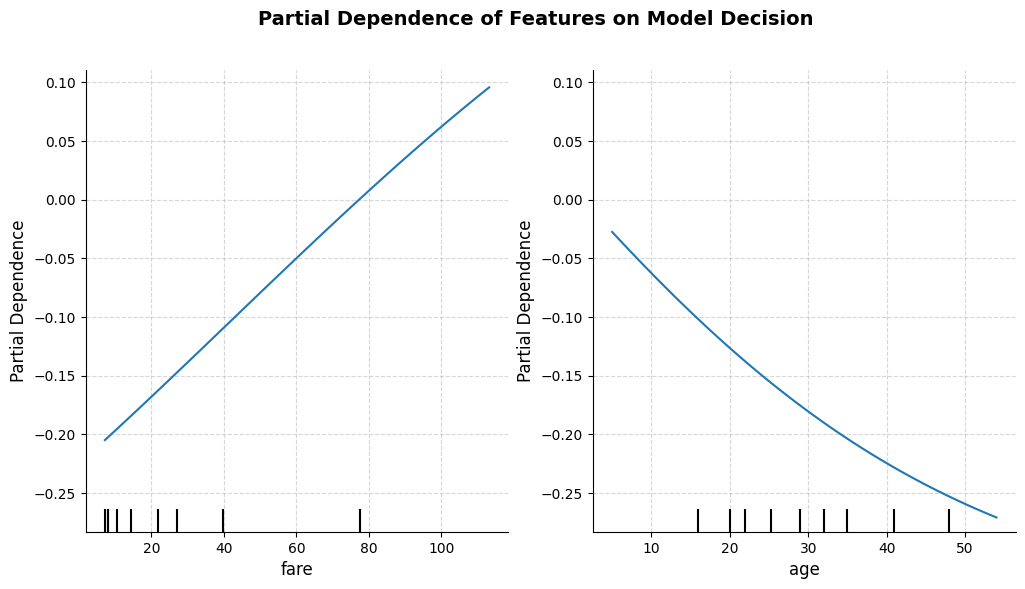

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Feature-i koje analiziramo
features = ['fare', 'age']

# Kreiranje PDP vizualizacije
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Generišemo Partial Dependence Plot
pdp = PartialDependenceDisplay.from_estimator(model, xtrain, features, ax=ax)

# Poboljšavanje izgleda grafika
for a in ax:
    a.grid(True, linestyle='--', alpha=0.5)  # Dodavanje mreže za lakše čitanje
    a.set_xlabel(a.get_xlabel(), fontsize=12)  # Veći font za ose
    a.set_ylabel("Partial Dependence", fontsize=12)
    a.spines['top'].set_visible(False)  # Uklanja gornji okvir
    a.spines['right'].set_visible(False)

# Naslov grafika
fig.suptitle("Partial Dependence of Features on Model Decision", fontsize=14, fontweight='bold')

# Prikaz grafika
plt.show()


In [71]:
rezultati.iloc[1:].mean().sort_values(ascending = False)

SVC       0.810768
SVC2      0.797720
ridge     0.792950
ridge2    0.792950
rf2       0.783487
knn       0.781305
knn2      0.781305
logit2    0.776822
logit3    0.776822
rf3       0.776476
logit     0.771547
rf        0.764979
dtype: float64

In [53]:
svc, ridge, rf, logit = joblib.load('titanikSVC.pkl'), joblib.load('titanikRidge.pkl'), joblib.load('titanikRf.pkl'), joblib.load('titanikLogit.pkl')

In [54]:
model = SVC(C=1.2589254117941673, gamma='auto', kernel='rbf', class_weight='balanced', probability= True, random_state= 42)
#MORA PROBABILITY = TRUE ZA SOFT GLASANJE
svc = Pipeline([('preproc', preprocessor), ('model', model)])
svc.fit(xtrain, ytrain)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['deck', 'class']),
                                                 ('dummy',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sibsp', 'parch', 'who',
                                                   'adult_male', 'embark_town',
                                                   'alone']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'fare'])])),
                ('model',
                 SVC(C=1.2589254117941673, class_weight='balanced',
                     gamma='auto', probability=True, random_state=42))])

In [55]:
sum(provera(svc)[1:]) / 3

np.float64(0.8067164234033314)

In [56]:
rezultati = joblib.load('titanikRezultati.pkl')

In [57]:
provera(svc)
rezultati['svc'] = provera(svc)

In [58]:
rezultati = rezultati.loc[:,['svc','ridge2','logit2','rf2']]
rezultati

,svc,ridge2,logit2,rf2
treningScore,0.821629,0.827247,0.844101,0.905899
testScore,0.832402,0.815642,0.810056,0.810056
roc,0.815020,0.804084,0.786034,0.794137
f1,0.772727,0.759124,0.734375,0.746269


In [59]:
rezultati

,svc,ridge2,logit2,rf2
treningScore,0.821629,0.827247,0.844101,0.905899
testScore,0.832402,0.815642,0.810056,0.810056
roc,0.815020,0.804084,0.786034,0.794137
f1,0.772727,0.759124,0.734375,0.746269


In [60]:
ridgeCal = CalibratedClassifierCV(ridge, method='sigmoid', cv=10)

In [61]:
soft = VotingClassifier(estimators= [('svc', svc), ('ridge', ridgeCal),('rf',rf), ('logit', logit)], voting='soft')

In [62]:
hard = VotingClassifier(estimators= [('svc', svc), ('ridge', ridge),('rf',rf), ('logit', logit)], voting='hard')

In [63]:
soft

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['deck',
                                                                                 'class']),
                                                                               ('dummy',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare'])])),
                                              ('model',
                                               SVC(C=1.2589254117941673,
                                                   class_weight='balanc...
                                                                                                 OneHotEncoder(drop='first',
                                                                                                               handle_unknown='ignore')),
                                                                                                ('poly',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True))]),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone',
                                                                                 'classDeck']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare',
                                                                                 'farePerPerson'])])),
                                              ('logit',
                                               LogisticRegression(C=np.float64(0.1),
                                                                  max_iter=500,
                                                                  solver='liblinear'))]))],
                 voting='soft')

In [64]:
%%time
soft.fit(xtrain, ytrain)

CPU times: total: 3.56 s
Wall time: 3.41 s


VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['deck',
                                                                                 'class']),
                                                                               ('dummy',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare'])])),
                                              ('model',
                                               SVC(C=1.2589254117941673,
                                                   class_weight='balanc...
                                                                                                 OneHotEncoder(drop='first',
                                                                                                               handle_unknown='ignore')),
                                                                                                ('poly',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True))]),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone',
                                                                                 'classDeck']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare',
                                                                                 'farePerPerson'])])),
                                              ('logit',
                                               LogisticRegression(C=np.float64(0.1),
                                                                  max_iter=500,
                                                                  solver='liblinear'))]))],
                 voting='soft')

In [65]:
rezultati['soft'] = provera(soft)
rezultati

,svc,ridge2,logit2,rf2,soft
treningScore,0.821629,0.827247,0.844101,0.905899,0.851124
testScore,0.832402,0.815642,0.810056,0.810056,0.843575
roc,0.815020,0.804084,0.786034,0.794137,0.826812
f1,0.772727,0.759124,0.734375,0.746269,0.787879


In [66]:
svc.named_steps['model']

SVC(C=1.2589254117941673, class_weight='balanced', gamma='auto',
    probability=True, random_state=42)

In [67]:
%%time
hard.fit(xtrain, ytrain)

CPU times: total: 3.03 s
Wall time: 2.72 s


VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('preproc',
                                               ColumnTransformer(transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['deck',
                                                                                 'class']),
                                                                               ('dummy',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare'])])),
                                              ('model',
                                               SVC(C=1.2589254117941673,
                                                   class_weight='balanc...
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder(drop='first',
                                                                                                               handle_unknown='ignore')),
                                                                                                ('poly',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True))]),
                                                                                ['sibsp',
                                                                                 'parch',
                                                                                 'who',
                                                                                 'adult_male',
                                                                                 'embark_town',
                                                                                 'alone',
                                                                                 'classDeck']),
                                                                               ('numeric',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'fare',
                                                                                 'farePerPerson'])])),
                                              ('logit',
                                               LogisticRegression(C=np.float64(0.1),
                                                                  max_iter=500,
                                                                  solver='liblinear'))]))])

In [68]:
rezultati['hard'] = provera(hard)
rezultati

,svc,ridge2,logit2,rf2,soft,hard
treningScore,0.821629,0.827247,0.844101,0.905899,0.851124,0.856742
testScore,0.832402,0.815642,0.810056,0.810056,0.843575,0.821229
roc,0.815020,0.804084,0.786034,0.794137,0.826812,0.800527
f1,0.772727,0.759124,0.734375,0.746269,0.787879,0.753846


In [69]:
rezultati.iloc[2:].mean().sort_values(ascending = False)

soft      0.807345
svc       0.793874
ridge2    0.781604
hard      0.777187
rf2       0.770203
logit2    0.760205
dtype: float64

In [70]:
pca3d = PCA(n_components=3)
pipe = Pipeline([('preproc', preprocessor), ('pca', pca3d),])
xprimetr = pipe.fit_transform(xtrain)
xprimetest = pipe.fit_transform(xtest)
prosek = np.mean(xprimetr[:, 2])
xprimetr, prosek

(array([[ 0.53299705, -0.74545577, -0.1688671 ],
        [-1.75049408, -1.3716514 , -0.82765917],
        [-3.04098519,  0.99553983, -1.12133009],
        ...,
        [ 0.46121235,  0.94274034,  2.16524056],
        [-0.59285847, -0.91541345,  0.81378784],
        [-2.1925182 , -1.36481979,  0.70014576]], shape=(712, 3)),
 np.float64(7.484649604214538e-17))

In [71]:
svcPCA = svc['model'].fit(xprimetr, ytrain)
ridgePCA = ridge['model'].fit(xprimetr, ytrain)
ridgePCA = CalibratedClassifierCV(estimator=ridge['model'], cv = 10).fit(xprimetr, ytrain)
rfPCA = rf['model'].fit(xprimetr, ytrain)
logitPCA = logit['logit'].fit(xprimetr, ytrain)

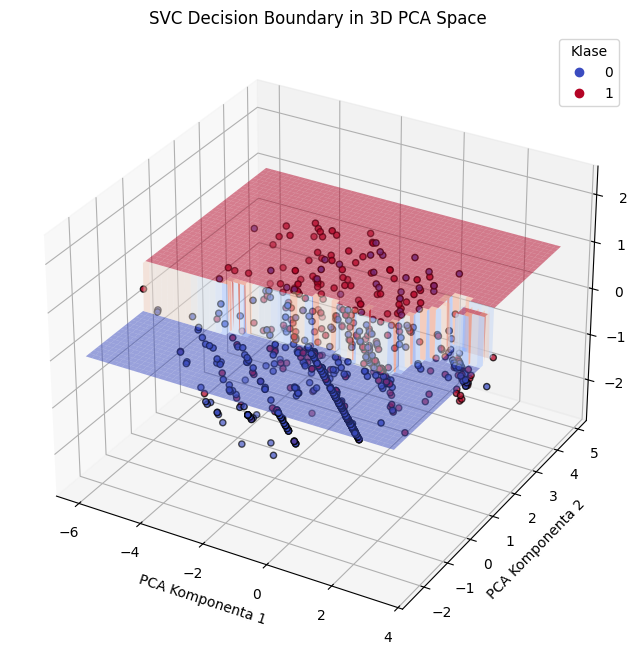

In [72]:
model = VotingClassifier(estimators= [('svc', svcPCA), ('ridge', ridgePCA),('rf',rfPCA), ('logit', logitPCA)], voting='soft')
model.fit(xprimetr, ytrain)

# Kreiranje meshgrid za 2D prostor sa 2 PCA komponente (početne dve komponente za odluku)
x1, x2 = np.meshgrid(np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 300),
                     np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 300))

# Pravimo mesh za predikcije (kombinacija dve komponente i treća je prosek)
prosek = np.median(xprimetr[:, 2])  # Prosek treće komponente
mesh = np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, prosek)]  # Dodajemo prosek za treću komponentu

# Predikcija za meshgrid (sa dve komponente)
z = model.predict(mesh)
z = z.reshape(x1.shape)  # Preoblikujemo rezultat u odgovarajući oblik za vizualizaciju

# Kreiraj 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prikazivanje originalnih podataka u 3D prostoru
scatter = ax.scatter(xprimetr[:, 0], xprimetr[:, 1], xprimetr[:, 2], c=ytrain, cmap='coolwarm', edgecolor='k')

# Dodavanje oznaka
ax.set_xlabel('PCA Komponenta 1')
ax.set_ylabel('PCA Komponenta 2')
ax.set_zlabel('PCA Komponenta 3')
ax.set_title('SVC Decision Boundary in 3D PCA Space')

# Prikazivanje legende
plt.legend(*scatter.legend_elements(), title="Klase")

# Dodavanje površinske plohe sa predikcijama (decision boundary)
# Prikazivanje odlučujuće granice u 3D prostoru
ax.plot_surface(x1, x2, z, cmap='coolwarm', alpha=0.5)

# Prikazivanje
plt.show()

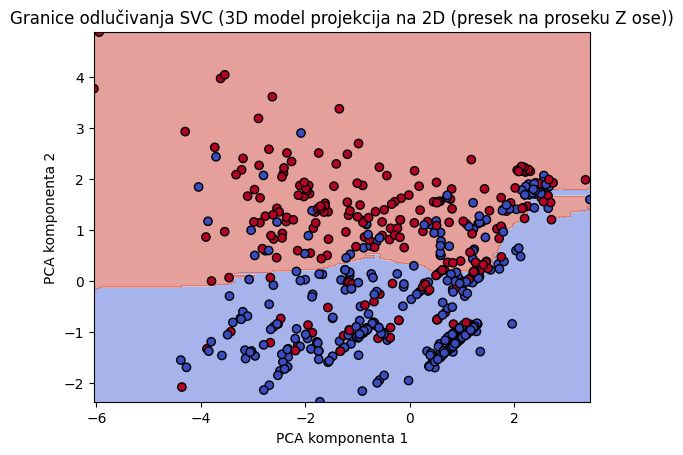

In [73]:
plt.contourf(x1, x2, z, alpha=0.5, cmap='coolwarm')
plt.scatter(xprimetr[:, 0], xprimetr[:, 1], c=ytrain, edgecolor='k', cmap='coolwarm')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.title('Granice odlučivanja SVC (3D model projekcija na 2D (presek na proseku Z ose))')
plt.show()

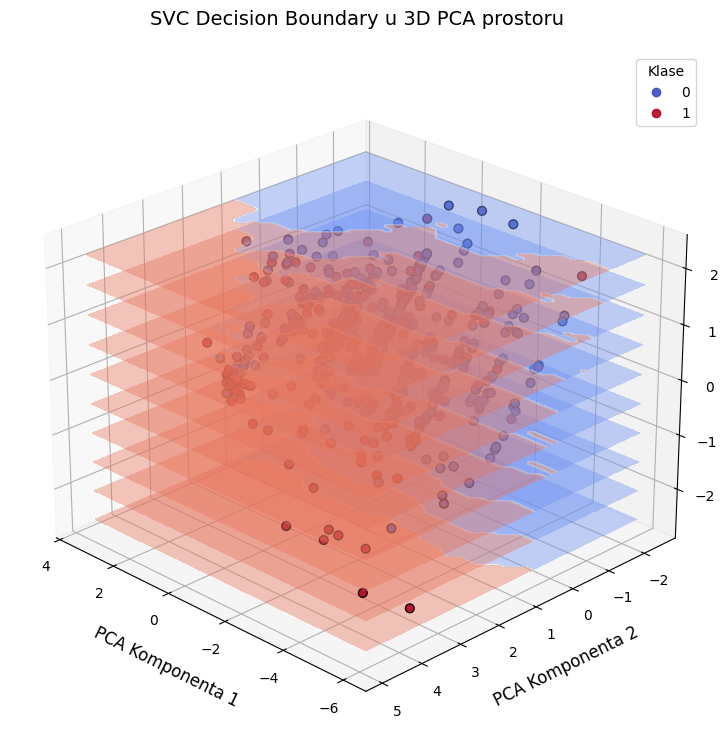

In [74]:
x1_range = np.linspace(xprimetr[:, 0].min(), xprimetr[:, 0].max(), 50)
x2_range = np.linspace(xprimetr[:, 1].min(), xprimetr[:, 1].max(), 50)
x3_range = np.linspace(xprimetr[:, 2].min(), xprimetr[:, 2].max(), 10)  # Smanjio broj slojeva

# Figura i 3D osa
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=135)  # Prilagođen ugao kamere

# Scatter plot originalnih podataka
scatter = ax.scatter(
    xprimetr[:, 0], xprimetr[:, 1], xprimetr[:, 2], 
    c=ytrain, cmap='coolwarm', edgecolor='k', s=40, alpha=0.9
)

# Crtamo slojeve odlučujuće granice kroz PCA3
for x3_val in x3_range:
    x1, x2 = np.meshgrid(x1_range, x2_range)
    grid_points = np.c_[x1.ravel(), x2.ravel(), np.full(x1.ravel().shape, x3_val)]

    # Model predviđa klase za svaki presek
    z = model.predict(grid_points)
    z = z.reshape(x1.shape)

    # Poboljšana odlučujuća granica
    ax.contourf(
        x1, x2, z, zdir='z', offset=x3_val, 
        cmap='coolwarm', alpha=0.4, levels=2
    )

# Oznake osa i naslov
ax.set_xlabel('PCA Komponenta 1', fontsize=12, labelpad=10)
ax.set_ylabel('PCA Komponenta 2', fontsize=12, labelpad=10)
ax.set_zlabel('PCA Komponenta 3', fontsize=12, labelpad=10)
ax.set_title('SVC Decision Boundary u 3D PCA prostoru', fontsize=14, pad=20)

# Prikazivanje legende
legend = ax.legend(*scatter.legend_elements(), title="Klase", fontsize=10, loc="upper right", frameon=True)
legend.get_frame().set_alpha(0.8)

# Prikazivanje
plt.show()


In [75]:
preproc_kmeans = ColumnTransformer([('numeric', StandardScaler(), numeric)])
kmeans_pipe = Pipeline([('preproc', preproc_kmeans),('kmeans', KMeans( random_state=42, n_init=10))])

preproc_svc = ColumnTransformer([('ordinal', OrdinalEncoder(), ordinal),('dummy', OneHotEncoder(handle_unknown='ignore'), dummy),
                                 ('numeric', StandardScaler(), numeric)])

feature_union = FeatureUnion([('preproc', preproc_svc),('kmeans', kmeans_pipe)])

finalPipe = Pipeline([('features', feature_union),('svc', svc['model'])])

param_grid = {'features__kmeans__kmeans__n_clusters': [i for i in range (3,59,2)]}

gridKmeans = GridSearchCV(finalPipe, param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=3)
gridKmeans.fit(xtrain, ytrain)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('preproc',
                                                                        ColumnTransformer(transformers=[('ordinal',
                                                                                                         OrdinalEncoder(),
                                                                                                         ['deck',
                                                                                                          'class',
                                                                                                          'familySize']),
                                                                                                        ('dummy',
                                                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                                                         ['sibsp',
                                                                                                          'parch',
                                                                                                          'who',
                                                                                                          'adult_male',
                                                                                                          'embark_town',
                                                                                                          'alone',
                                                                                                          'classDeck']),
                                                                                                        ('numeric',
                                                                                                         StandardScaler(),
                                                                                                         ['age',
                                                                                                          'fare...
                                                                                                                           'farePerPerson'])])),
                                                                                        ('kmeans',
                                                                                         KMeans(n_init=10,
                                                                                                random_state=42))]))])),
                                       ('svc',
                                        SVC(C=1.2589254117941673,
                                            class_weight='balanced',
                                            gamma='auto', probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'features__kmeans__kmeans__n_clusters': [3, 5, 7, 9,
                                                                  11, 13, 15,
                                                                  17, 19, 21,
                                                                  23, 25, 27,
                                                                  29, 31, 33,
                                                                  35, 37, 39,
                                                                  41, 43, 45,
                                                                  47, 49, 51,
                                                                  53, 55, 57]},
             scoring='balanced_accuracy', verbose=3)

In [76]:
rezultati['svc_KMeans'] = provera(gridKmeans)
rezultati

,svc,ridge2,logit2,rf2,soft,hard,svc_KMeans
treningScore,0.821629,0.827247,0.844101,0.905899,0.851124,0.856742,0.821618
testScore,0.832402,0.815642,0.810056,0.810056,0.843575,0.821229,0.791304
roc,0.815020,0.804084,0.786034,0.794137,0.826812,0.800527,0.791304
f1,0.772727,0.759124,0.734375,0.746269,0.787879,0.753846,0.744828


In [78]:
param_grid2 = {'features__kmeans__kmeans__n_clusters': [i for i in range (3,21,2)]}

gridKmeans2 = GridSearchCV(finalPipe, param_grid2, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=3)
gridKmeans2.fit(xtrain, ytrain)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('preproc',
                                                                        ColumnTransformer(transformers=[('ordinal',
                                                                                                         OrdinalEncoder(),
                                                                                                         ['deck',
                                                                                                          'class',
                                                                                                          'familySize']),
                                                                                                        ('dummy',
                                                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                                                         ['sibsp',
                                                                                                          'parch',
                                                                                                          'who',
                                                                                                          'adult_male',
                                                                                                          'embark_town',
                                                                                                          'alone',
                                                                                                          'classDeck']),
                                                                                                        ('numeric',
                                                                                                         StandardScaler(),
                                                                                                         ['age',
                                                                                                          'fare...
                                                                                         ColumnTransformer(transformers=[('numeric',
                                                                                                                          StandardScaler(),
                                                                                                                          ['age',
                                                                                                                           'fare',
                                                                                                                           'farePerPerson'])])),
                                                                                        ('kmeans',
                                                                                         KMeans(n_init=10,
                                                                                                random_state=42))]))])),
                                       ('svc',
                                        SVC(C=1.2589254117941673,
                                            class_weight='balanced',
                                            gamma='auto', probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'features__kmeans__kmeans__n_clusters': [3, 5, 7, 9,
                                                                  11, 13, 15,
                                                                  17, 19]},
             scoring='balanced_accuracy', verbose=3)

In [79]:
rezultati['svc_KMeans2'] = provera(gridKmeans2)
rezultati

,svc,ridge2,logit2,rf2,soft,hard,svc_KMeans,svc_KMeans2
treningScore,0.821629,0.827247,0.844101,0.905899,0.851124,0.856742,0.821618,0.828698
testScore,0.832402,0.815642,0.810056,0.810056,0.843575,0.821229,0.791304,0.784058
roc,0.815020,0.804084,0.786034,0.794137,0.826812,0.800527,0.791304,0.784058
f1,0.772727,0.759124,0.734375,0.746269,0.787879,0.753846,0.744828,0.736111


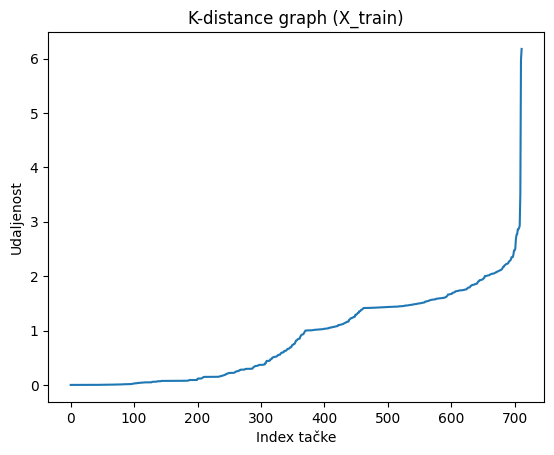

In [80]:
nnPipe = Pipeline([('prep', preprocessor), ('model', NearestNeighbors(n_neighbors=5))])
nnPipe.fit(xtrain)

xtrainPrep = nnPipe['prep'].transform(xtrain)
distances, indices = nnPipe['model'].kneighbors(xtrainPrep)

distances = np.sort(distances[:,4])

plt.plot(distances)
plt.title('K-distance graph (X_train)')
plt.xlabel('Index tačke')
plt.ylabel('Udaljenost')
plt.show()

In [81]:
nnPipe['model'].kneighbors(xtrainPrep)[0]

array([[0.        , 0.        , 0.0442096 , 0.0442096 , 0.25052108],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.74839309, 2.475721  , 2.47758456, 2.50200677],
       ...,
       [0.        , 1.43772039, 1.475363  , 1.48450158, 1.50051617],
       [0.        , 0.25950721, 0.26886846, 0.38572144, 0.44765304],
       [0.        , 0.22210178, 0.25052108, 0.38314989, 0.67797731]],
      shape=(712, 5))

In [82]:
distances[-30:]

array([2.17194702, 2.17211991, 2.19578554, 2.20584995, 2.21488247,
       2.22351887, 2.22564176, 2.23305642, 2.2392775 , 2.26893137,
       2.27633535, 2.28796972, 2.3015863 , 2.34674275, 2.34674275,
       2.34929271, 2.38799304, 2.47114878, 2.4733259 , 2.50200677,
       2.68015694, 2.76154333, 2.76949381, 2.86102115, 2.86224832,
       2.88403238, 2.92608166, 3.50975079, 5.96866688, 6.17675456])

In [83]:
nnPipe['model'].kneighbors(xtrainPrep)[0][56]

array([0.        , 0.        , 0.0442096 , 0.0442096 , 0.25052108])

In [84]:
nnPipe['model'].kneighbors(xtrainPrep)[1][56]

array([  0,  56, 412, 197, 532])

In [85]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(xtrainPrep)

In [86]:
len(set(clusters)) - (1 if -1 in clusters else 0)

7

In [87]:
np.sum(clusters == -1)

np.int64(104)

In [88]:
clusters[:10]

array([ 0,  0, -1, -1,  1,  0,  0, -1,  0,  1])

In [89]:
pca = PCA(n_components=2, random_state= 42)
X_pca = pca.fit_transform(xtrainPrep)

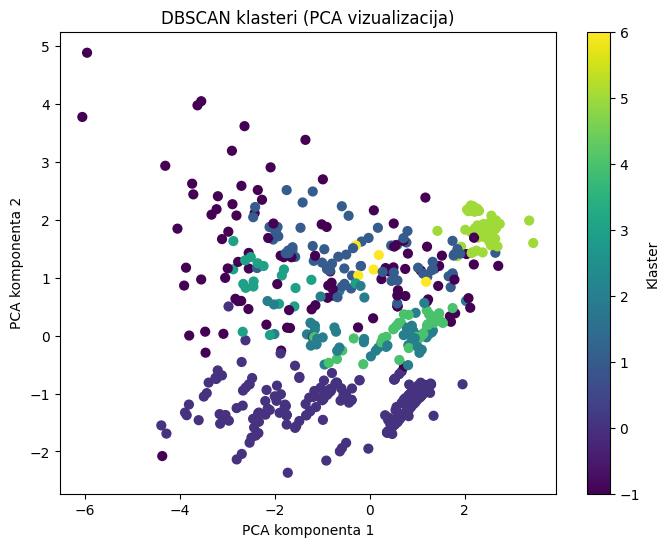

In [90]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

In [194]:
for i in np.linspace(1,2,70):
    dbscan = DBSCAN(eps=i, min_samples=5)
    clusters = dbscan.fit_predict(xtrainPrep)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = np.sum(clusters == -1)
    
    print(f'eps={i}: broj klastera={n_clusters}, šum={n_noise}')

eps=1.0: broj klastera=22, šum=321
eps=1.0144927536231885: broj klastera=14, šum=295
eps=1.0289855072463767: broj klastera=15, šum=284
eps=1.0434782608695652: broj klastera=15, šum=279
eps=1.0579710144927537: broj klastera=15, šum=266
eps=1.0724637681159421: broj klastera=15, šum=264
eps=1.0869565217391304: broj klastera=15, šum=261
eps=1.1014492753623188: broj klastera=15, šum=257
eps=1.1159420289855073: broj klastera=16, šum=250
eps=1.1304347826086956: broj klastera=15, šum=247
eps=1.144927536231884: broj klastera=14, šum=244
eps=1.1594202898550725: broj klastera=14, šum=244
eps=1.1739130434782608: broj klastera=14, šum=240
eps=1.1884057971014492: broj klastera=14, šum=240
eps=1.2028985507246377: broj klastera=14, šum=240
eps=1.2173913043478262: broj klastera=15, šum=235
eps=1.2318840579710144: broj klastera=15, šum=232
eps=1.2463768115942029: broj klastera=15, šum=231
eps=1.2608695652173914: broj klastera=15, šum=230
eps=1.2753623188405796: broj klastera=15, šum=230
eps=1.2898550724

In [92]:
len(np.linspace(1,2,10))

10

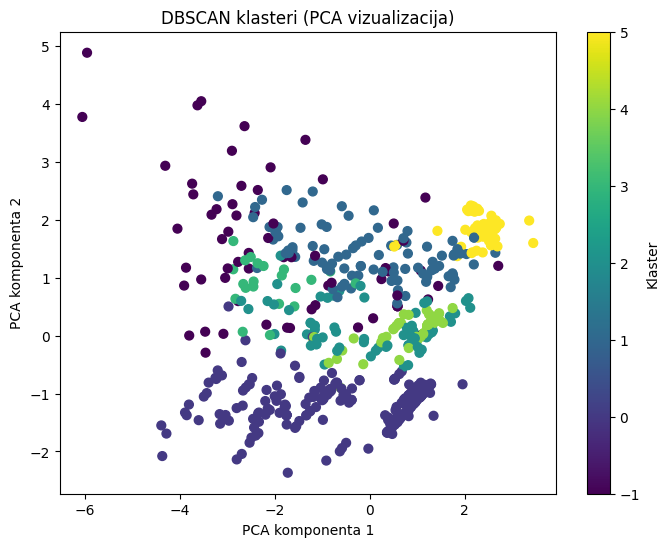

In [93]:
dbscan = DBSCAN(eps=1.65, min_samples=5)
clusters = dbscan.fit_predict(xtrainPrep)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

In [94]:
df_clusters = xtrain.copy()
df_clusters['cluster'] = clusters
df_clusters[numeric].groupby(clusters).mean()
# print(df_clusters.groupby(clusters).mean())

,age,fare,farePerPerson
-1,33.040308,120.416348,64.87105
0,33.154848,14.750640,14.75064
1,31.620000,41.441317,17.610021
2,31.792958,30.208162,13.236192
3,30.685714,82.962495,82.962495
4,27.062162,9.973653,9.973653
5,5.732143,24.981698,6.162678


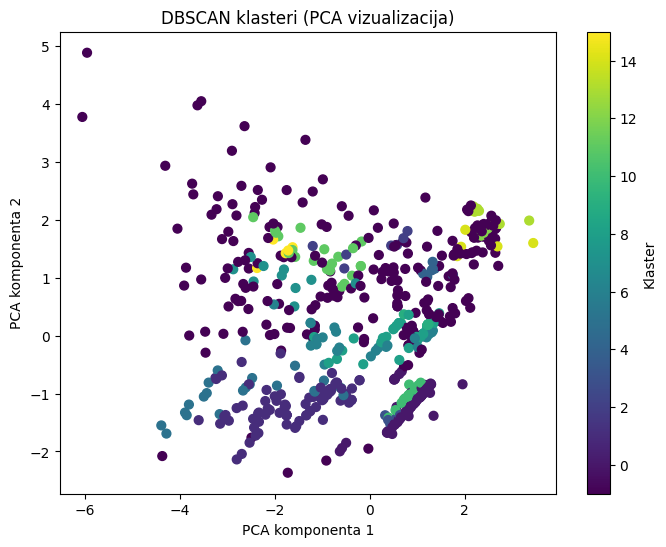

In [95]:
dbscan = DBSCAN(eps=1.3, min_samples=5)
clusters = dbscan.fit_predict(xtrainPrep)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

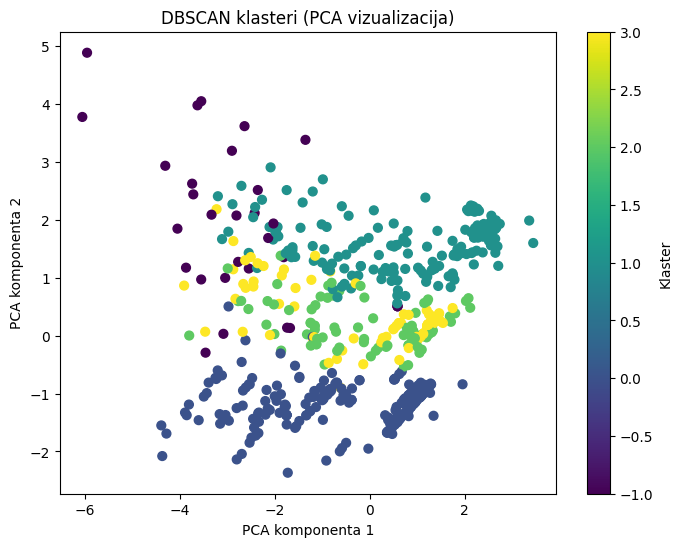

In [97]:
dbscan = DBSCAN(eps=1.95, min_samples=5)
clusters = dbscan.fit_predict(xtrainPrep)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

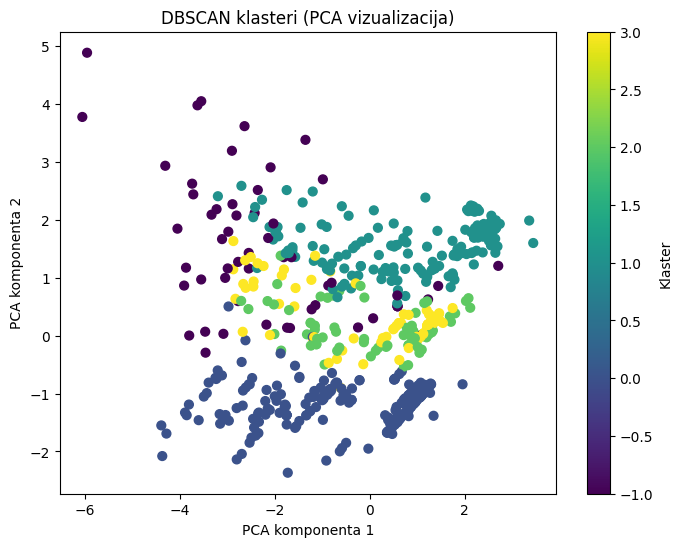

In [131]:
dbscan = DBSCAN(eps=1.75, min_samples=5)
klaster = dbscan.fit_predict(xtrainPrep)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=klaster, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

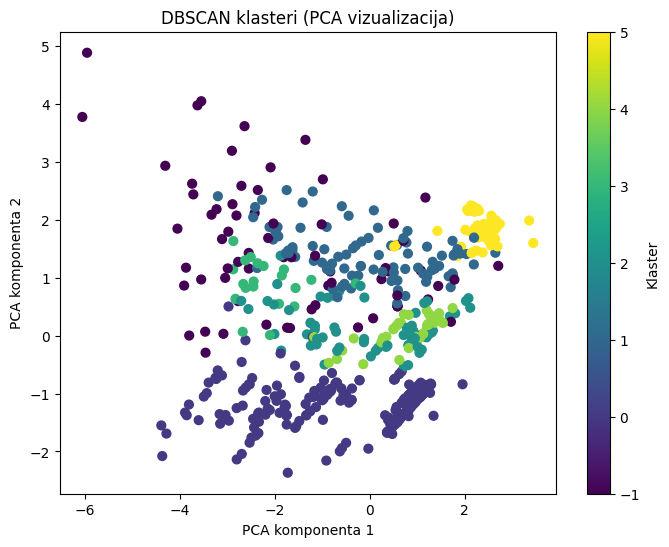

In [132]:
dbscan = DBSCAN(eps=1.6, min_samples=5)
klaster = dbscan.fit_predict(xtrainPrep)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=klaster, cmap='viridis', s=40)
plt.title('DBSCAN klasteri (PCA vizualizacija)')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.colorbar(label='Klaster')
plt.show()

In [133]:
xtrainPrep.shape

(712, 29)

In [134]:
nnPipe['prep'].fit_transform(xtrain).shape

(712, 29)

In [137]:
klaster.shape, xtrain.shape

((712,), (712, 13))

In [142]:
klaster = pd.Series(klaster, index = xtrain.index, name= 'klaster')

In [152]:
xtrainKlaster = pd.concat((xtrain,klaster), axis = 1)
xtrainKlaster

,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone,familySize,farePerPerson,classDeck,klaster
692,31.4,0,0,56.4958,Third,man,True,E,Southampton,True,1,56.4958,Third_E,0
481,33.4,0,0,0.0000,Second,man,True,B,Southampton,True,1,0.0,Second_B,0
527,33.4,0,0,221.7792,First,man,True,C,Southampton,True,1,221.7792,First_C,-1
855,18.0,0,1,9.3500,Third,woman,False,F,Southampton,False,2,4.675,Third_F,1
801,31.0,1,1,26.2500,Second,woman,False,E,Southampton,False,3,8.75,Second_E,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,21.7,0,0,7.8792,Third,woman,False,E,Queenstown,True,1,7.8792,Third_E,4
258,35.0,0,0,512.3292,First,woman,False,B,Cherbourg,True,1,512.3292,First_B,-1
736,48.0,1,3,34.3750,Third,woman,False,E,Southampton,False,5,6.875,Third_E,1
462,47.0,0,0,38.5000,First,man,True,E,Southampton,True,1,38.5,First_E,0


In [199]:
svc['preproc']

ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                 ['deck', 'class']),
                                ('dummy',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sibsp', 'parch', 'who', 'adult_male',
                                  'embark_town', 'alone']),
                                ('numeric', StandardScaler(), ['age', 'fare'])])

In [207]:
svcKlasterPipe = Pipeline([('prep', svc['preproc']) , ('model', SVC())])

grid = {
    'model__C': np.logspace(0.1, 1.5, 30),
    'model__kernel': ['rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto'],
    'model__class_weight': ['balanced'],
}
svcKlaster = RandomizedSearchCV(estimator=svcKlasterPipe, param_distributions=grid,
                                n_iter=50, cv=7,n_jobs=-1, verbose=3, scoring='balanced_accuracy', random_state=42)
svcKlaster.fit(xtrainKlaster, ytrain)

Fitting 7 folds for each of 50 candidates, totalling 350 fits


RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('ordinal',
                                                                               OrdinalEncoder(),
                                                                               ['deck',
                                                                                'class']),
                                                                              ('dummy',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sibsp',
                                                                                'parch',
                                                                                'who',
                                                                                'adult_male',
                                                                                'embark_town',
                                                                                'alone']),
                                                                              ('numeric',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'fare'])])),
                                             ('model', SVC())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={...
        3.8261203 ,  4.27596836,  4.77870636,  5.34055272,  5.968457  ,
        6.67018579,  7.45441888,  8.33085653,  9.31033949, 10.4049831 ,
       11.62832714, 12.99550329, 14.5234223 , 16.23098318, 18.13930694,
       20.27199786, 22.65543544, 25.31910069, 28.29594078, 31.6227766 ]),
                                        'model__class_weight': ['balanced'],
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['rbf', 'sigmoid']},
                   random_state=42, scoring='balanced_accuracy', verbose=3)

In [210]:
rezultati['svcKlaster'] = provera(svcKlaster)
rezultati

,svc,ridge2,logit2,rf2,soft,hard,svc_KMeans,svc_KMeans2,svcKlaster
treningScore,0.821629,0.827247,0.844101,0.905899,0.851124,0.856742,0.821618,0.828698,0.834794
testScore,0.832402,0.815642,0.810056,0.810056,0.843575,0.821229,0.791304,0.784058,0.790448
roc,0.815020,0.804084,0.786034,0.794137,0.826812,0.800527,0.791304,0.784058,0.790448
f1,0.772727,0.759124,0.734375,0.746269,0.787879,0.753846,0.744828,0.736111,0.742857


In [202]:
svc['model']

SVC(C=1.2589254117941673, class_weight='balanced', gamma='auto',
    probability=True, random_state=42)

In [191]:
xtrainKlaster['klaster'][xtrainKlaster['klaster'] == -1].sum()

np.int64(-69)